In [1]:
# Choose geoprocessing kernel
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns

import scipy
import warnings
import os
import shapely
import rasterio 
import pickle
from rasterio.features import geometry_mask
from PIL import Image

In [4]:
# Datasets to be compared
site_name = "kolguev" #"Herschel, kolguev, tuktoyaktuk, taymyr, Peel. # Depends on the data name, csv produced with feature_calculation.ipynb 

name = "Sophia"
lab1_name = 'labeler 1'
name2 = "Kathrin"
lab2_name = 'labeler 2'


# name = "Kathrin"
# lab1_name = 'labeler 2'
# name2 = "Philipp"
# lab2_name = 'labeler 3'


# name = "Sophia"
# lab1_name = 'labeler 1'
# name2 = "Philipp"
# lab2_name = 'labeler 3'




In [5]:
# Read result from feature_calculation.ipynb
if site_name == "Peel":
    lab1 = pd.read_csv(f"Aggregated_{name}.csv")
    lab2 = pd.read_csv(f"Aggregated_{name2}.csv")
else:
    lab1 = pd.read_csv(f"{site_name}_{name}.csv")
    lab2 = pd.read_csv(f"{site_name}_{name2}.csv")
if site_name == 'Peel' and name2 == "Philipp":
    lab1 = lab1[lab1.year_end == 2016]

In [7]:
# Get start and end year of measurement
start_ = list(set(list(np.unique(lab1['year_start'])) + list(np.unique(lab2['year_start']))))
end_ = list(set(list(np.unique(lab1['year_end'])) + list(np.unique(lab2['year_end']))))
print(start_, end_)

[2010] [2016, 2018]


In [8]:
# Set path to data
local_folder = os.getcwd()
file_folder = r'C:\Users\sophi\Documents\thesis\code\comparing labels\labeled_data'  # UNC path
polygons_1 = gpd.read_file(os.path.join(local_folder, file_folder, f"{site_name}_{name}.geojson"))
polygons_2 = gpd.read_file(os.path.join(local_folder, file_folder, f"{site_name}_{name2}.geojson"))

# Make sure start and end year is in int format
#if name in ["Philipp", "Kathrin"]:
polygons_1['year_start'] = polygons_1['year_start'].astype(int)
polygons_1['year_end'] = polygons_1['year_end'].astype(int)
print(f"Changed year from str to int in {name}")
#if name2 in ["Philipp", "Kathrin"]:
polygons_2['year_start'] = polygons_2['year_start'].astype(int)
polygons_2['year_end'] = polygons_2['year_end'].astype(int)
print(f"Changed year from str to int in {name2}")

Changed year from str to int in Sophia
Changed year from str to int in Kathrin


In [9]:
if site_name == 'Peel' and name2 == "Philipp":
    polygons_1 = polygons_1[polygons_1.year_end == 2016]

In [10]:
# make sure columnname is correctly defined as tile_name
if site_name == 'tuktoyaktuk':
    polygons_1.rename(columns={'tile_range': 'tile_name'}, inplace=True)
    polygons_2.rename(columns={'tile_range': 'tile_name'}, inplace=True)

In [11]:
# For IoU it is not important if there are multiple DEM images per RTS -> remove rows where RTS id is not unique
# In dataset, id is for each delineated RTS. If RTS is on two tiles, it is saved twice, each with one tile name. This redundancy needs to be thrown away for iou calculation 
dataset1 = polygons_1[~polygons_1['id'].duplicated(keep='first')]
dataset2 = polygons_2[~polygons_2['id'].duplicated(keep='first')]

# Check number of duplicates and unique RTS
unique = polygons_1["id"].drop_duplicates(keep=False)
boolean_unique = polygons_1["id"].isin(unique)
non_unique = polygons_1["id"][~boolean_unique]

unique2 = polygons_2["id"].drop_duplicates(keep=False)
boolean_unique2 = polygons_2["id"].isin(unique2)
non_unique2 = polygons_2["id"][~boolean_unique2]
print(f"{len(np.unique(non_unique))} RTS appear more than once in df (Because it overlaps multiple tiles). Each id is a unique RTS, we have {len(unique)} unique RTS and in total {len(np.unique(polygons_1.id))} RTS for labeler 1")
print(f"{len(np.unique(non_unique2))} RTS appear more than once in df (Because it overlaps multiple tiles). Each id is a unique RTS, we have {len(unique2)} unique RTS and in total {len(np.unique(polygons_2.id))} RTS for labeler 1")

polygons_1 = dataset1
polygons_2 = dataset2

0 RTS appear more than once in df (Because it overlaps multiple tiles). Each id is a unique RTS, we have 56 unique RTS and in total 56 RTS for labeler 1
0 RTS appear more than once in df (Because it overlaps multiple tiles). Each id is a unique RTS, we have 48 unique RTS and in total 48 RTS for labeler 1


In [14]:
# get tile names
if site_name == 'Peel':
    with open(os.path.join(os.getcwd(), 'tile_name.pkl'), 'rb') as file:
        tile_name = pickle.load(file)
else:
    # Get union of both lists
    tile_name = set(polygons_1.tile_name.tolist()) | set(polygons_1.tile_name.tolist())

In [15]:
# Build iou_values df (initialized with twice the size of polygons_1)
iou_col_name = ['polygon1_id', 'polygon2_id', 'IoU']
iou_values = pd.DataFrame(None,  index=range(len(polygons_1)*2), columns=iou_col_name)

In [16]:
# Fill iou_values
n_RTS_pair_count = 0 
# iterate through tiles: We only want to extract IoU if RTS is in same tile. ------------------------------------------------------------------------
for tile in tile_name:

    # All possible start / end date
    year_start = start_
    year_end = end_

    # Extract sub_df according to tilename
    sub_polygons_image1 = polygons_1[polygons_1["tile_name"] ==  tile]
    sub_polygons_image2 = polygons_2[polygons_2["tile_name"] ==  tile]

    # iterate through all combination of years------------------------------------------------------------------------
    # Makes sure that all tiles are read, create sub df based on chosen start and end year
    for start in year_start:
        for end in year_end:
            sub_polygons1 = sub_polygons_image1[(sub_polygons_image1["year_start"] == start) & (sub_polygons_image1["year_end"] == end)]
            sub_polygons2 = sub_polygons_image2[(sub_polygons_image2["year_start"] == start) & (sub_polygons_image2["year_end"] == end)]

            # Only read image if there is at least one RTS in image to avoid unnecessary tasks
            if len(sub_polygons1)>0 and len(sub_polygons2)>0:

                # Iterate through each pair of polygons from the sub df (Where tilename and start/end year match) and calculate intersection
                for idx1, row1 in sub_polygons1.iterrows():
                    for idx2, row2 in sub_polygons2.iterrows():
                        if row1["tile_name"] == row2["tile_name"]: # redundant check
                            intersection = gpd.overlay(gpd.GeoDataFrame(geometry=[row1['geometry']]),
                                                    gpd.GeoDataFrame(geometry=[row2['geometry']]),
                                                    how='intersection')

                            # only append if intersection is not empty, fill values (polygon1 id, polygon2 id) into df
                            if not intersection.area.empty:
                                # If initialized iou_values df was not big enough -> expand by 50 rows
                                if n_RTS_pair_count > iou_values.shape[0]: 
                                    df_expand = pd.DataFrame(0, index=range(50), columns= iou_col_name)
                                    iou_values = pd.concat([iou_values, df_expand])
                                iou_values.at[n_RTS_pair_count, 'polygon1_id'] = row1['id']
                                iou_values.at[n_RTS_pair_count, 'polygon2_id'] = row2['id']
                                intersection_area = intersection.area[0]
                                
                                # Calculate union area
                                union_area = row1['geometry'].union(row2['geometry']).area

                                # Calculate IoU and fill it into df
                                iou = intersection_area / union_area
                                iou_values.at[n_RTS_pair_count, 'IoU'] = iou      
                                n_RTS_pair_count+=1                         

                           
                            

                                
                                

In [17]:
# Df was initialized with a "random" size -> might not be fully filled -> Drop unfilled rows
iou_values = iou_values.iloc[:n_RTS_pair_count]
iou_values.to_csv(f'{site_name}_{name}_{name2}_iou_raw.csv', index=True)

In [38]:
# In order to compare labellers, we only want one IoU per RTS (e.g. if one RTS overlaps with two other RTS, we only want to look at the pair with the bigger IoU)
# To match the most possible RTS between labellers we don't want to solely match RTS pairs with the biggest IoU. The goal is to match as many RTS as possible, so if choosing a pair with a lower IoU allows pair matching between an additional RTS pair, this combination is chose
# Algorithm:
'''
Group according to RTS_id1 (first RTS in the RTS pair)
Sort each group in descending order of IoU: On top of each group is the RTS pair with highest IoU
Extract the RTS pairs with highest IoU. Now RTS_1 is unqiue. If RTS_2 is not unique --> RTS pair don't have a 1:1 relationship.  
    While RTS_2 is not unique: 
     For each not unique RTS_2: all pairs with corresponding RTS_2. Replace the pair (with RTS_2_x) with lowest IoU --> by replacing RTS_2_x with the RTS that has the 2nd highest IoU with RTS_1_x
    If pair (with RTS_2_x) with lowest IoU cannot be replaced (because RTS_1_x has no other match), we look into replacing RTS_2_y with 2nd lowest IoU --> by replacing RTS_2_y with the RTS that has the 2nd highest IoU with RTS_1_y
    Continue
'''
# df iou_unique only keeps unique RTS pairs (1:1 relationship) First initialization contains pairs where RTS_1 has highest IoU
iou_unique = iou_values.copy(deep=True)
iou_sorted = iou_values.groupby('polygon1_id').apply(lambda x: x.sort_values(by='IoU', ascending=False)).reset_index(drop=True)
iou_unique = iou_sorted.groupby('polygon1_id').first().reset_index()

In [39]:
# Create dictionary to keep track of each RTS_id1 which x highest IoU it is currently keeping
# p1_id = ID of RTS_1. All filled with 1, because we start by keeping the 1st highest IoU
round = {p1_id: 1 for p1_id in iou_unique.polygon1_id}
# Repeat until polygon2_id is unique (unitl 1:1 relationship is reached)
while iou_unique['polygon2_id'].duplicated().any():
    #print(iou_unique)
    # Get all polygon2_id of RTS pair that are not unique in polygon2_id
    non_unique_array = np.unique(iou_unique[iou_unique.duplicated('polygon2_id')]['polygon2_id'])

    # For each not unique RTS_2:
    for id2_replace in non_unique_array: 
        # Extract sub df with all pairs containing RTS_2. Sort according to IoU (ascending)
        sub_non_unique = iou_unique[iou_unique["polygon2_id"]== id2_replace]
        sub_non_unique = sub_non_unique.sort_values(by="IoU")

        # Replace one RTS pair (RTS_1_a, RTS_2_a), starting from the one with smallest IoU
            # Replace with pair (RTS_1_a, RTS_2_x) which has (round) biggest IoU of all IoU with RTS_1_a
            # If (RTS_1_a, RTS_2_a) pair cannot be replaced because there is no other pair with RTS_1_a --> 
            # Try to replace RTS pair (RTS_1_b, RTS_2_a2) with (replace_row th) smallest IoU of all IoU with RTS_2_a. 
                # If no RTS pair can be replaced -> exclude RTS pair with smallest IoU (RTS_1_a, RTS_2_a)

        replace_row = 0
        while replace_row < len(sub_non_unique): # If row cannot be replaced because no corresponding polyogn1_id is available
            id1_replace = sub_non_unique.iloc[replace_row]["polygon1_id"]
            fill =  iou_sorted[iou_sorted["polygon1_id"] == id1_replace]

            if len(fill)>round[id1_replace]:
                # replace
                iou_unique[(iou_unique["polygon1_id"]== id1_replace)& (iou_unique["polygon2_id"]== id2_replace)] = fill.iloc[round[id1_replace]]
                round[id1_replace] += 1
                
                break 
            else: 
                replace_row+=1
        if replace_row == len(sub_non_unique): # no row was able to be replaced, exclude from unique df
            sub_non_unique.iloc[0]["polygon1_id"]
            iou_unique = iou_unique[~((iou_unique["polygon1_id"]== id1_replace)&(iou_unique["polygon2_id"]== id2_replace))]

In [205]:
iou_unique.to_csv(f'{site_name}_{name}_{name2}_iou_paired.csv', index=True)

### Get summary

In [155]:
# Datasets to be compared
site_name = "Peel" #"Herschel"

name = "Sophia"
lab1_name = 'labeler 1'
name2 = "Kathrin"
lab2_name = 'labeler 2'


# name = "Kathrin"
# lab1_name = 'labeler 2'
# name2 = "Philipp"
# lab2_name = 'labeler 3'


# name = "Sophia"
# lab1_name = 'labeler 1'
# name2 = "Philipp"
# lab2_name = 'labeler 3'




In [4]:
if site_name == 'Peel':
    iou_values = pd.read_csv(f"{name}_{name2}_iou_raw.csv")
    iou_unique = pd.read_csv(f"{name}_{name2}_iou_paired.csv")
else:
    iou_unique = pd.read_csv(f"{site_name}_{name}_{name2}_iou_paired.csv")
    iou_values = pd.read_csv(f"{site_name}_{name}_{name2}_iou_raw.csv")

In [41]:
print(len(iou_unique), name, name2)

46 Sophia Kathrin


In [42]:
np.round(iou_unique.IoU.mean(),2)

0.69

In [43]:
np.round(iou_values.IoU.mean(),2)

0.67

In [44]:
print('Total IoU pairs:', len(iou_values))
print('Total L1:',len(dataset1))
print('Total L2:',len(dataset2))

Total IoU pairs: 52
Total L1: 56
Total L2: 48


In [45]:

# Find RTS instances that have no pair -> set IoU to 0
id1_missing = np.unique(dataset1[~dataset1["id"].isin(iou_values["polygon1_id"])]["id"])
id2_missing = np.unique(dataset2[~dataset2["id"].isin(iou_values["polygon2_id"])]["id"])
print('No intersection L1:', len(id1_missing))
print('No intersection L2', len(id2_missing))
print('total',  len(id1_missing) + len(id2_missing))

No intersection L1: 4
No intersection L2 2
total 6


In [46]:
# Only keep RTS within site
polygons_1_clean = polygons_1#[polygons_1.tile_name.notna()]
polygons_2_clean = polygons_2#[polygons_2.tile_name.notna()]


In [47]:
print('1:1 matched:', len(iou_unique))

# Find RTS instances that have no pair -> set IoU to 0
id1_missing = np.unique(iou_values[~iou_values["polygon1_id"].isin(iou_unique["polygon1_id"])]["polygon1_id"])
id2_missing = np.unique(iou_values[~iou_values["polygon2_id"].isin(iou_unique["polygon2_id"])]["polygon2_id"])
print('Unmatched L1', len(id1_missing))
print('Unmatched L2', len(id2_missing))
print('total',len(id1_missing) + len(id2_missing))

1:1 matched: 46
Unmatched L1 6
Unmatched L2 0
total 6


In [48]:
# N RTS match
print('TP:', sum(iou_unique['IoU']>=0.5))
print('FP:', sum(iou_unique['IoU']<0.5))

TP: 38
FP: 8


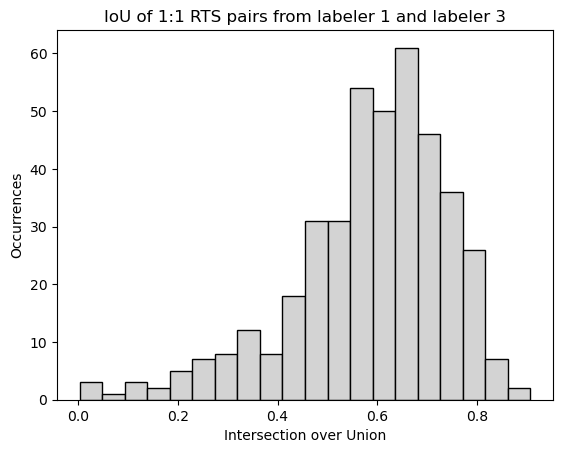

In [213]:
plt.hist(iou_unique["IoU"], color='lightgrey', edgecolor='black', bins=20)
plt.xlabel('Intersection over Union')
plt.ylabel('Occurrences')
plt.title(f'IoU of 1:1 RTS pairs from {lab1_name} and {lab2_name}')

plt.savefig(f'{site_name}_1_1_IoU_{lab1_name}_{lab2_name}.png', format='png', dpi=300)
# plt.savefig('1_1_IoU_lab2_lab3.svg', format='svg')
plt.show()

In [294]:
data1 = {
    'polygon1_id': id1_missing,
    'polygon2_id': [None] * len(id1_missing),
    'IoU': [0] * len(id1_missing)
}

data2 = {
    'polygon1_id': [None] * len(id2_missing),
    'polygon2_id': id2_missing,
    'IoU': [0] * len(id2_missing)
}

id1_df = pd.DataFrame(data1)

id2_df = pd.DataFrame(data2)

In [111]:
low_iou = iou_unique[iou_unique['IoU']< 0.5] #.drop('Unnamed: 0', axis=1)
unmatched = pd.concat([id1_df, id2_df, low_iou])

In [112]:
notfound = pd.concat([id1_df, id2_df])

In [123]:
merged_df1 = iou_unique.merge(lab1.add_prefix('1_')[['1_id', '1_type', '1_geometry', '1_area', '1_perimeter', '1_circularity', '1_solidity', '1_diameter_max', '1_n_vertices', '1_norm_std', '1_norm_median','1_norm_mean']],
                              left_on='polygon1_id', right_on='1_id', how='left')

merged_df = merged_df1.merge(lab2.add_prefix('2_')[['2_id', '2_type', '2_geometry', '2_area', '2_perimeter', '2_circularity', '2_solidity', '2_diameter_max', '2_n_vertices', '2_norm_std', '2_norm_median','2_norm_mean']],
                              left_on='polygon2_id', right_on='2_id', how='left')

In [124]:
unmatched_merg1 = unmatched.merge(lab1.add_prefix('1_')[['1_id', '1_type', '1_geometry', '1_area', '1_perimeter', '1_circularity', '1_solidity',  '1_diameter_max', '1_n_vertices', '1_norm_std', '1_norm_median','1_norm_mean']],
                              left_on='polygon1_id', right_on='1_id', how='left')
unmatched_merged = unmatched_merg1.merge(lab2.add_prefix('2_')[['2_id', '2_type', '2_geometry', '2_area', '2_perimeter', '2_circularity', '2_solidity', '2_diameter_max', '2_n_vertices', '2_norm_std', '2_norm_median','2_norm_mean']],
                              left_on='polygon2_id', right_on='2_id', how='left')

In [125]:
notfound1 = notfound.merge(lab1.add_prefix('1_')[['1_id', '1_type', '1_geometry', '1_area', '1_perimeter', '1_circularity', '1_solidity',  '1_diameter_max', '1_n_vertices', '1_norm_std', '1_norm_median','1_norm_mean']],
                              left_on='polygon1_id', right_on='1_id', how='left')
notfound_ = notfound1.merge(lab2.add_prefix('2_')[['2_id', '2_type', '2_geometry', '2_area', '2_perimeter', '2_circularity', '2_solidity', '2_diameter_max', '2_n_vertices', '2_norm_std', '2_norm_median','2_norm_mean']],
                              left_on='polygon2_id', right_on='2_id', how='left')


In [129]:
# Features of unmatched
feature_unmatch = unmatched_merged[['1_area', '1_perimeter', '1_circularity', '1_solidity', '1_diameter_max', '1_n_vertices', '1_norm_std', '1_norm_median','1_norm_mean', '2_area', '2_perimeter', '2_circularity', '2_solidity', '2_diameter_max', '2_n_vertices', '2_norm_std', '2_norm_median','2_norm_mean']].mean().round(2)
unmatched_ = pd.DataFrame(feature_unmatch)
unmatched_

,0
1_area,12825.80
1_perimeter,444.94
1_circularity,0.67
1_solidity,0.90
1_diameter_max,156.76
1_n_vertices,13.61
1_norm_std,0.68
1_norm_median,1.21
1_norm_mean,1.24
2_area,6727.84


In [130]:
# features of matched
matched_df = merged_df[merged_df['IoU']>=0.5]
a = matched_df[['1_area', '1_perimeter', '1_circularity', '1_solidity', '1_diameter_max', '1_n_vertices', '1_norm_std', '1_norm_median','1_norm_mean', '2_area', '2_perimeter', '2_circularity', '2_solidity', '2_diameter_max', '2_n_vertices', '2_norm_std', '2_norm_median','2_norm_mean']].mean().round(2)
matched_ = pd.DataFrame(a)
matched_

,0
1_area,13308.06
1_perimeter,502.75
1_circularity,0.63
1_solidity,0.86
1_diameter_max,175.58
1_n_vertices,15.38
1_norm_std,0.64
1_norm_median,1.17
1_norm_mean,1.18
2_area,13603.29


### Calculate accuracy score ect.

In [7]:
iou_tot = pd.read_csv("Kathrin_Philipp_iou_raw.csv")

# Get pair with max Iou
iou_tot_sorted = iou_tot.groupby('polygon1_id').apply(lambda x: x.sort_values(by='IoU', ascending=False)).reset_index(drop=True)
iou_tot_max = iou_tot_sorted.groupby('polygon1_id').first().reset_index()

In [13]:
IoU_thresh = 0.5
# Unmatched id 1 if  iou < thresh--------
boolean_iou = iou_tot_max["IoU"] >= IoU_thresh
id1_matched = np.unique(iou_tot_max['polygon1_id'][boolean_iou])
id1_unmatched_iou = np.unique(iou_tot_max['polygon1_id'][~boolean_iou])

# unmatched id2 if iou < thresh
id2_unmatched_iou = np.unique(iou_tot_max['polygon2_id'][~boolean_iou])

# unmatched id1 if not in iou -----------
boolean_in_iou = np.isin(dataset1['id'].values, iou_tot_max['polygon1_id'].values)
id1_unmatched2 = dataset1['id'][~boolean_in_iou]

# unmatched id2 if not in iou 
boolean_id2in_iou = np.isin(dataset2['id'].values, iou_tot_max['polygon2_id'].values)
id2_unmatched2 = dataset2['id'][~boolean_id2in_iou]

id1_unmatched = np.concatenate((id1_unmatched_iou, id1_unmatched2))
id2_unmatched = np.concatenate((id2_unmatched_iou, id2_unmatched2))

TP_ = len(boolean_iou)
FP_ = len(id1_unmatched)
FN_ = len(id2_unmatched)
accuracy_special = TP_/(TP_+FP_+FN_)
precision = TP_ / (TP_ + FP_)
recall = TP_ / (TP_ + FN_)


In [14]:
accuracy_special, precision, recall

(0.2504145936981758, 0.2707710699342499, 0.769100169779287)